In [1]:
import pandas as pd

In [2]:
csv_path = "Houses Dataset/HousesInfo.txt"
cols = ["bedrooms","bathrooms", "area", "zipcode", "price"]
df = pd.read_csv(csv_path, sep=" ", header=None, names=cols)

In [3]:
import os
import glob
import numpy as np
import cv2

In [4]:
images = []
inputPath = 'Houses Dataset'


for i in df.index.values:
    basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
    housePaths = sorted(list(glob.glob(basePath)))

    inputImages = []
    outputImage = np.zeros((64, 64, 3), dtype="uint8")

    for housePath in housePaths:
        image = cv2.imread(housePath)
        image = cv2.resize(image, (32, 32))
        inputImages.append(image)

    outputImage[0:32, 0:32] = inputImages[0]
    outputImage[0:32, 32:64] = inputImages[1]
    outputImage[32:64, 32:64] = inputImages[2]
    outputImage[32:64, 0:32] = inputImages[3]
    images.append(outputImage)

In [5]:
# return our set of images
images = np.array(images)

In [6]:
import matplotlib.pyplot as plt

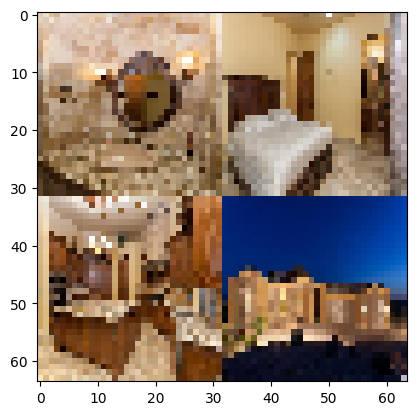

In [7]:
plt.imshow(cv2.cvtColor(images[1], code=cv2.COLOR_BGR2RGB))

In [8]:
images.shape

(535, 64, 64, 3)

In [9]:
images = images / 255.0

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X = df.drop(['zipcode', 'price'], axis = 1)
y = df['price']

In [12]:
trainAttrX, testAttrX, trainImagesX, testImagesX = train_test_split(df, images, test_size=0.25, random_state=42)

In [13]:
testAttrX

,bedrooms,bathrooms,area,zipcode,price
117,3,2.5,1915,92021,485000
132,3,2.5,2248,92677,1199000
154,3,1.0,1132,96019,170000
245,6,4.0,3375,92880,538000
84,3,2.5,2733,91901,689000
...,...,...,...,...,...
490,3,2.0,2108,93446,439000
155,3,2.0,1372,96019,178000
423,4,4.0,3254,93510,674900
354,2,2.0,1930,92276,164900


In [14]:
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice

In [15]:
X_train = trainAttrX.drop(['zipcode', 'price'], axis = 1)
X_test = testAttrX.drop(['zipcode', 'price'], axis = 1)

y_train = trainAttrX['price']
y_train = testAttrX['price']

In [16]:
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

X_test -= mean
X_test /= std

In [17]:
from keras.models import Sequential
from keras.layers import Dense

#define our MLP network
dim = X_train.shape[1]

mlp = Sequential()
mlp.add(Dense(8, input_dim=dim, activation='relu'))
mlp.add(Dense(4, activation='relu'))
# mlp.add(Dense(1)) # only for regression

In [18]:
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, BatchNormalization
from keras.layers import MaxPooling2D, Flatten, Dropout

inputShape = (64, 64, 3)
chanDim = -1

# define the model input
inputs = Input(shape=inputShape)
x = inputs

# CONV => RELU => BN => POOL
x = Conv2D(16, (3, 3), padding="same", activation='relu')(x)
x = BatchNormalization(axis=chanDim)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, (3, 3), padding="same", activation='relu')(x)
x = BatchNormalization(axis=chanDim)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), padding="same", activation='relu')(x)
x = BatchNormalization(axis=chanDim)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# flatten the volume, then FC => RELU => BN => DROPOUT
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
x = BatchNormalization(axis=chanDim)(x)
x = Dropout(0.5)(x)

x = Dense(4, activation='relu')(x)
# x = Dense(1, activation="linear")(x) # only for regression

# construct the CNN
cnn = Model(inputs, x)

In [19]:
from keras.layers import concatenate

combinedInput = concatenate([mlp.output, cnn.output])
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

model.compile(loss="mean_absolute_percentage_error", optimizer='adam')

In [34]:
# !pip install pydot
# !pip install graphviz

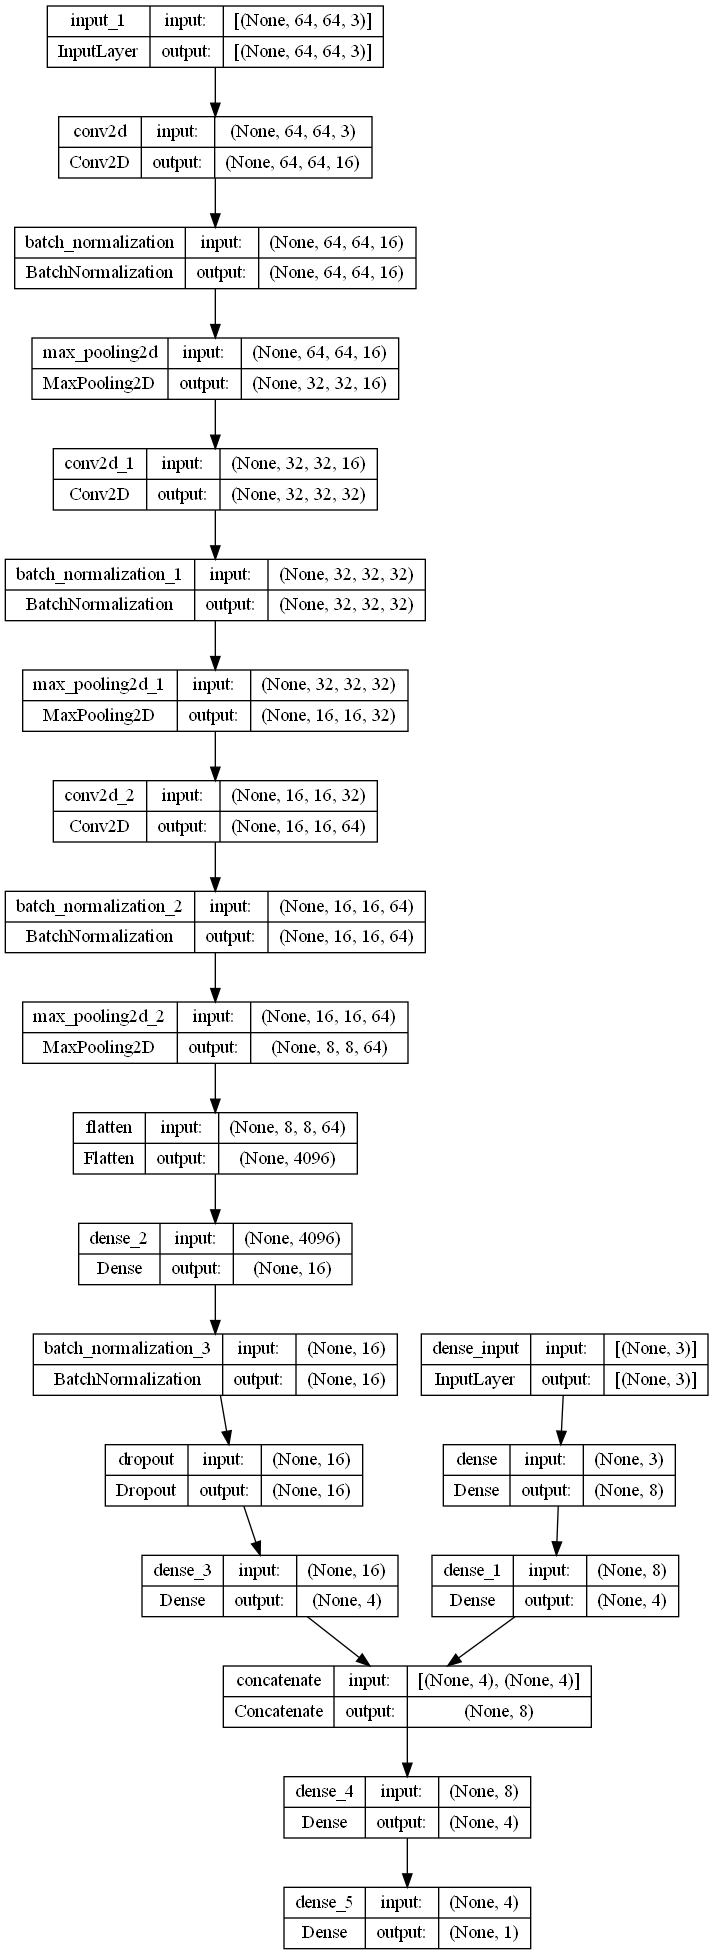

In [20]:
import keras

keras.utils.plot_model(model, show_shapes=True)

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 16)           448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 16)           64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)           0         ['batch_normalization[0]

In [22]:
model.compile(loss="mean_absolute_percentage_error", optimizer='adam')

In [23]:
# train the model
print("[INFO] training model...")
model.fit([X_train, trainImagesX], trainY,
          validation_data=([X_test, testImagesX], testY),
          epochs=200, batch_size=8)

[INFO] training model...
Epoch 1/200
51/51 [==============================] - 2s 17ms/step - loss: 867.3813 - val_loss: 227.9099
Epoch 2/200
51/51 [==============================] - 1s 14ms/step - loss: 392.1571 - val_loss: 316.8633
Epoch 3/200
51/51 [==============================] - 1s 13ms/step - loss: 253.7974 - val_loss: 1172.2290
Epoch 4/200
51/51 [==============================] - 1s 13ms/step - loss: 168.5665 - val_loss: 1053.2643
Epoch 5/200
51/51 [==============================] - 1s 13ms/step - loss: 131.6813 - val_loss: 1333.8503
Epoch 6/200
51/51 [==============================] - 1s 13ms/step - loss: 115.1180 - val_loss: 554.3505
Epoch 7/200
51/51 [==============================] - 1s 13ms/step - loss: 88.5920 - val_loss: 677.7994
Epoch 8/200
51/51 [==============================] - 1s 13ms/step - loss: 73.6697 - val_loss: 762.9819
Epoch 9/200
51/51 [==============================] - 1s 13ms/step - loss: 86.8763 - val_loss: 376.5917
Epoch 10/200
51/51 [===================

51/51 [==============================] - 1s 13ms/step - loss: 33.8277 - val_loss: 50.7234
Epoch 81/200
51/51 [==============================] - 1s 13ms/step - loss: 33.1571 - val_loss: 51.6716
Epoch 82/200
51/51 [==============================] - 1s 13ms/step - loss: 37.5307 - val_loss: 59.0375
Epoch 83/200
51/51 [==============================] - 1s 13ms/step - loss: 34.3450 - val_loss: 52.3121
Epoch 84/200
51/51 [==============================] - 1s 13ms/step - loss: 33.9606 - val_loss: 48.0111
Epoch 85/200
51/51 [==============================] - 1s 14ms/step - loss: 32.8488 - val_loss: 50.8612
Epoch 86/200
51/51 [==============================] - 1s 15ms/step - loss: 31.4113 - val_loss: 50.0927
Epoch 87/200
51/51 [==============================] - 1s 15ms/step - loss: 32.8837 - val_loss: 50.5665
Epoch 88/200
51/51 [==============================] - 1s 14ms/step - loss: 32.6365 - val_loss: 47.7165
Epoch 89/200
51/51 [==============================] - 1s 14ms/step - loss: 31.8221 - v

51/51 [==============================] - 1s 13ms/step - loss: 25.3773 - val_loss: 49.2433
Epoch 160/200
51/51 [==============================] - 1s 13ms/step - loss: 26.7778 - val_loss: 45.4098
Epoch 161/200
51/51 [==============================] - 1s 13ms/step - loss: 25.3691 - val_loss: 47.6786
Epoch 162/200
51/51 [==============================] - 1s 13ms/step - loss: 28.1086 - val_loss: 51.0065
Epoch 163/200
51/51 [==============================] - 1s 13ms/step - loss: 26.4661 - val_loss: 58.5511
Epoch 164/200
51/51 [==============================] - 1s 13ms/step - loss: 25.8813 - val_loss: 55.7794
Epoch 165/200
51/51 [==============================] - 1s 13ms/step - loss: 27.1964 - val_loss: 74.6285
Epoch 166/200
51/51 [==============================] - 1s 14ms/step - loss: 27.6021 - val_loss: 49.4316
Epoch 167/200
51/51 [==============================] - 1s 14ms/step - loss: 28.2464 - val_loss: 54.0965
Epoch 168/200
51/51 [==============================] - 1s 14ms/step - loss: 25

In [24]:
# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict([X_test, testImagesX])

[INFO] predicting house prices...
5/5 [==============================] - 0s 8ms/step


In [25]:
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

In [26]:
import locale

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
    locale.currency(df["price"].mean(), grouping=True),
    locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $589,362.81, std house price: $509,026.07
[INFO] mean: 46.07%, std: 45.95%
